In [1]:
import struct
import zlib
from pynbt import NBTFile
import io
import os
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap


def translate_chunk_location(x, z, h_offset):
    # Calculate the chunk coordinates
    c_x = h_offset % 32
    c_z = h_offset // 32

    # Now, `offset` is the location of the chunk's data in the file,
    # and `x` and `z` are the chunk's coordinates within this region.
    # print(f"Chunk at [{x}({c_x}), {z}({c_z})] has an offset of {h_offset}")
    x_min = (x * 16) + (c_x * 16)
    x_max = (x * 16) + (c_x * 16) + 16
    z_min = (z * 16) + (c_z * 16)
    z_max = (z * 16) + (c_z * 16) + 16

    # print(f"Chunk covers [{x_min}, {z_min}] [{x_min}, {z_max}] [{x_max}, {z_min}] [{x_max}, {z_max}]")

    return c_x, c_z


def get_chunk_offset_and_length(header, i):
    # Extract the four bytes for this chunk entry
    entry_bytes = header[i * 4: i * 4 + 4]

    # The first three bytes are the offset (big-endian)
    offset = int.from_bytes(entry_bytes[:3], 'big')

    # The fourth byte is the length
    length = entry_bytes[3]

    return offset, length
    

def read_region_file(filepath):
    # Get the filename from path.
    filename = filepath.split('/')[-1]

    # Filename format is r.x.z.mca
    filesplit = filename.split('.')

    # X and Z coords are parts 1 and 2 of the filename.
    x = int(filesplit[1])
    z = int(filesplit[2])
    
    chunks = {}
    filename = f'data/region/r.{x}.{z}.mca'
    with open(filename, 'rb') as file:
        # Region files begin with an 8192 byte header
        header = file.read(8192)

        # locations (1024 entries)
        for i in range(0, 1024):
            offset, length = get_chunk_offset_and_length(header, i)
            
            if offset == 0 and length == 0:
                continue  # Chunk is not present
                
            # Convert the offset to bytes (multiply by 4096)
            offset *= 4096

            # check past offset
            file.seek(0, 2)  # end to of file
            if file.tell() < offset: 
                # offset is past file, no chunk exists
                continue

            # goto offset and read 
            file.seek(offset)
            chunk_header = file.read(5)  # Read chunk length and compression type
            if len(chunk_header) < 5:
                print(f"Incomplete chunk header for chunk {i}.")
                continue

            chunk_length, compression_type = struct.unpack('>IB', chunk_header)
            chunk_length -= 1  # Subtract the compression type byte

            # Read and decompress the chunk data
            compressed_chunk_data = file.read(chunk_length)
            if len(compressed_chunk_data) < chunk_length:
                print(f"Incomplete chunk data for chunk {i}.")
                continue

            
            chunks[translate_chunk_location(x, z, i)] = zlib.decompress(compressed_chunk_data)
            # chunks[(x, z, i)] = zlib.decompress(compressed_chunk_data)
    return chunks
        

In [2]:
def read_block_section(block_states_section, block_type_full_palette):
    # Need size of palette to calculate bit-size
    palette_size = len(block_states_section['palette'])

    # Iterate over the palette to add them to the full palette
    for palette in block_states_section['palette']:
        # If there is no entry for the palette then add one
        block_type_full_palette.setdefault(palette['Name'].value, len(block_type_full_palette))

    # If there is only 1 entry in the palette
    # Tne entire section is that entry
    if palette_size == 1:
        # Create an array that contains the single value from the palette
        block_type_array = np.full((16,16,16), block_type_full_palette[block_states_section['palette'][0]['Name'].value])
        return block_type_array

    # Bit size is 4 or least number of bits required to represent largest index 
    bit_size = max(4, math.ceil(math.log2(palette_size)))
    
    # Create an empty array to store the block states
    block_type_array = np.empty((16,16,16), dtype=int)

    
    # element = block_states_section['data'].value[0]
    # print(block_states_section['data'])
    current_idx = 0
    
    # Get block data
    for element in block_states_section['data'].value:
        # We start reading from 0 
        bits_read = 0
        
        # Keep reading until we get to 64 bits
        while bits_read + bit_size <= 64:
            # Shift element to the bits_read, then mask so we only read bit_size
            index = (element >> bits_read) & ((1 << bit_size) - 1)
            # Insert into the array the index of the palette from the full biome palette
            # Convert current idx into yzx coords
            yxz_coords = get_coords(current_idx, 16)
            # The index we want is the index of the palette from the full palette
            full_palette_index = block_type_full_palette[block_states_section['palette'][index]['Name'].value]
            # Store the value of the index in the multi dim array
            try:
                block_type_array[yxz_coords] = full_palette_index
            except Exception as e:
                print(f"current_idx={current_idx}")
                print(f"yxz_coords={yxz_coords}")
            # Step forward to read next bits
            bits_read += bit_size
            # Next idx
            current_idx += 1
    
    return block_type_array

In [3]:
def read_biome_section(biome_section, biome_full_palette):
    # Need size of palette to calculate bit-size
    palette_size = len(biome_section['palette'])

    # Iterate over the palette to add them to the full palette
    for palette in biome_section['palette']:
        # If there is no entry for the palette then add one
        biome_full_palette.setdefault(palette.value, len(biome_full_palette))

    # If there is only 1 entry in the palette
    # Tne entire section is that entry
    if palette_size == 1:
        biome_array = np.full((4,4,4), biome_full_palette[biome_section['palette'][0].value])
        return biome_array

    # Bit size is least number of bits required to represent largest index 
    bit_size = math.ceil(math.log2(palette_size)) 

    indices = []
    # Create an empty array to store the biome
    biome_array = np.empty((4,4,4), dtype=int)
    current_idx = 0

    # Get biome data
    for element in biome_section['data'].value:
        # We start reading from 0 
        bits_read = 0
        
        # Keep reading until we get to 64 bits
        while bits_read + bit_size <= 64:
            # Shift element to the bits_read, then mask so we only read bit_size
            index = (element >> bits_read) & ((1 << bit_size) - 1)
            indices.append(index)
            # Convert current idx into yzx coords
            yxz_coords = get_coords(current_idx, 4)
            # The index we want is the index of the palette from the full palette
            full_palette_index = biome_full_palette[biome_section['palette'][index].value]
            # Store the value of the index in the multi dim array
            biome_array[yxz_coords] = full_palette_index
            
            # Step forward to read next bits
            bits_read += bit_size
            # Next idx
            current_idx += 1
        
            # # Insert into the array the index of the palette from the full biome palette
            # biome_array[get_coords(idx, 4)] = biome_full_palette[biome_section['palette'][index].value]
            # bits_read += bit_size
    
        biomes = [biome_section['palette'][index].value for index in indices]
    
    return biome_array

In [4]:
def get_coords(idx, section_size):
    y = idx % section_size
    z = (idx // section_size) % section_size
    x = idx // (section_size * section_size)
    return x, y, z


In [5]:
def plot_subchunk(subchunk_array, palette_dict):
    # Extract unique values and sort them
    unique_values = sorted(set(palette_dict.values()))
    
    # Create a colormap
    cmap = matplotlib.colormaps['viridis'](np.linspace(0, 1, len(unique_values)))
    
    # Create a mapping from integer values to colors
    value_to_color = {val: cmap[i] for i, val in enumerate(unique_values)}
    
    # Prepare voxel subchunk_array for plotting
    voxel_data = {val: (subchunk_array == val) for val in unique_values}
    
    # Creating the plot
    fig = plt.figure(figsize=(40, 8), constrained_layout=True)
    ax = fig.add_subplot(111, projection='3d')
    
    # Plotting each set of voxels
    for val in unique_values:
        ax.voxels(voxel_data[val], facecolors=value_to_color[val], edgecolor='k')
    
    # Creating a custom legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=value_to_color[val], markersize=10) 
               for label, val in palette_dict.items() if val in unique_values]
    ax.legend(handles=handles, title="Labels", loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

    plt.show()


In [6]:
def read_chunk(the_chunk, biome_full_palette, block_full_palette):
    # convert to bytes to io stream and read
    chunk_data = io.BytesIO(the_chunk)
    nbt = NBTFile(chunk_data)
    
    
    #print(nbt.pretty())
    
    for idx, section in enumerate(nbt['sections']):
        print(section['Y'])
        sub_chunk = read_block_section(section['block_states'], block_full_palette)
        plot_subchunk(sub_chunk, block_full_palette)

In [7]:
fnames = os.listdir('data/region/')

all_chunks = {}
biome_full_palette = {}
block_full_palette = {}

for fname in fnames:
    print(fname)
    file_chunks = read_region_file(f'data/region/{fname}')
    print(f"Loaded {len(file_chunks)} chunks.")
    all_chunks.update(file_chunks)

r.-1.-1.mca
Loaded 288 chunks.
r.-1.0.mca
Loaded 142 chunks.
r.-2.-1.mca
Loaded 209 chunks.
r.-2.0.mca
Loaded 117 chunks.


TAG_Byte(-4, 'Y')


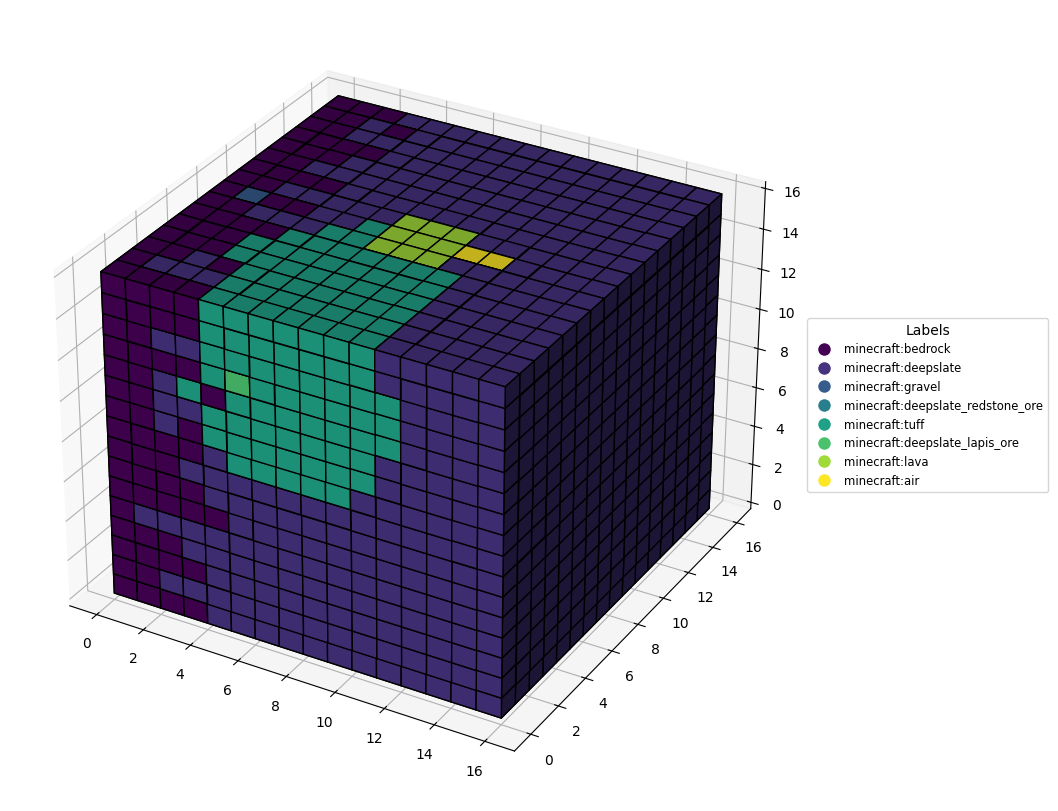

TAG_Byte(-3, 'Y')


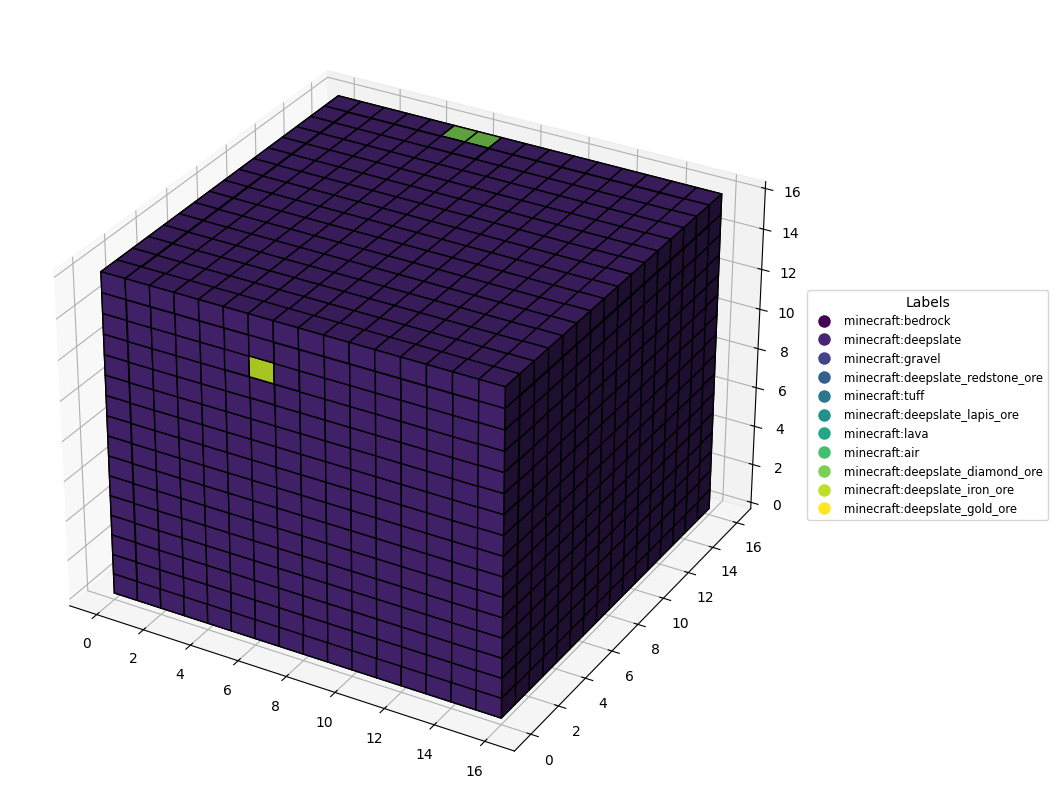

TAG_Byte(-2, 'Y')


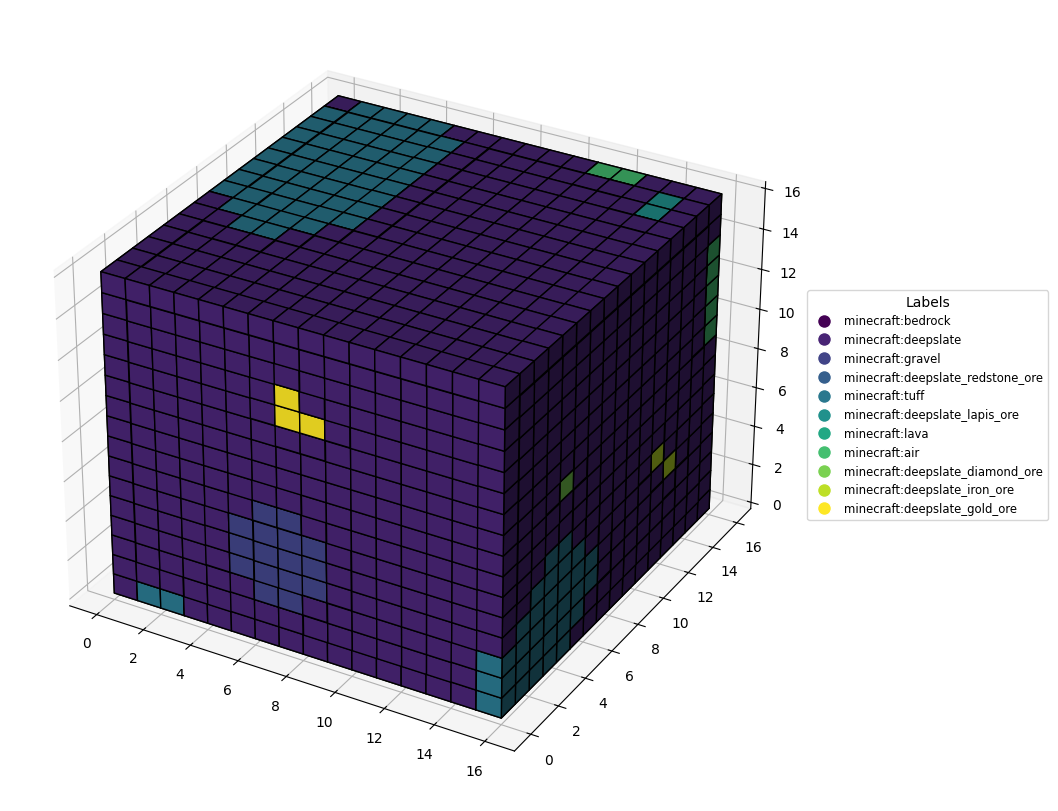

TAG_Byte(-1, 'Y')


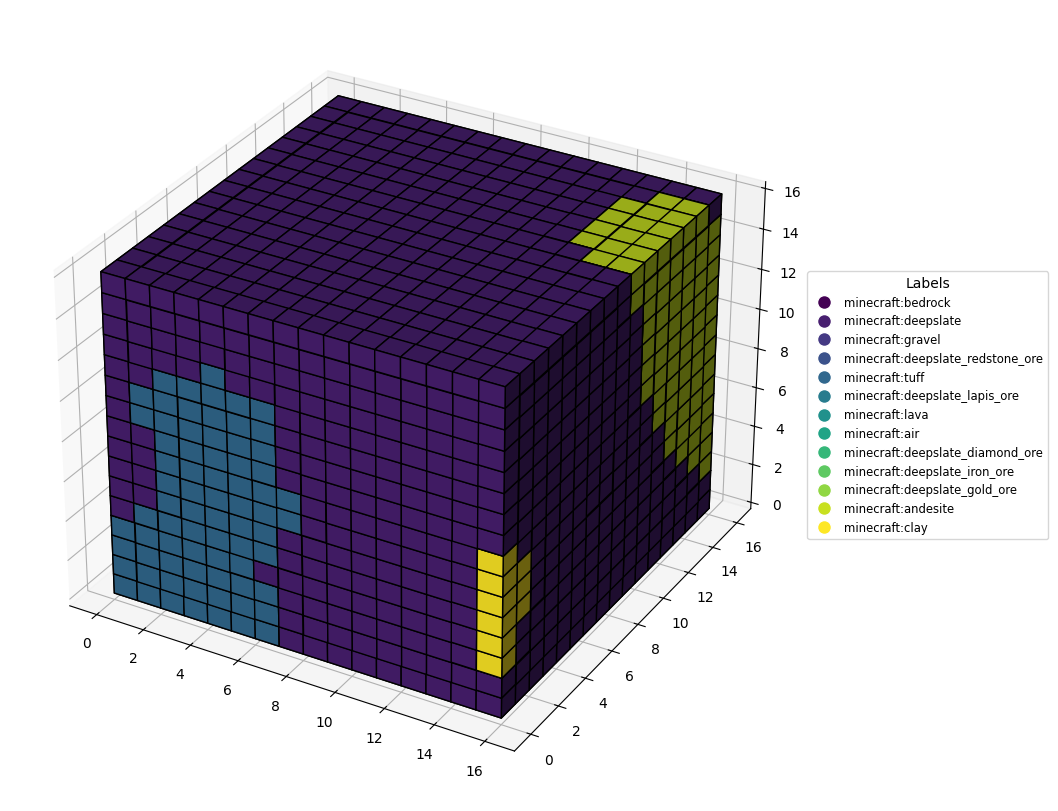

TAG_Byte(0, 'Y')


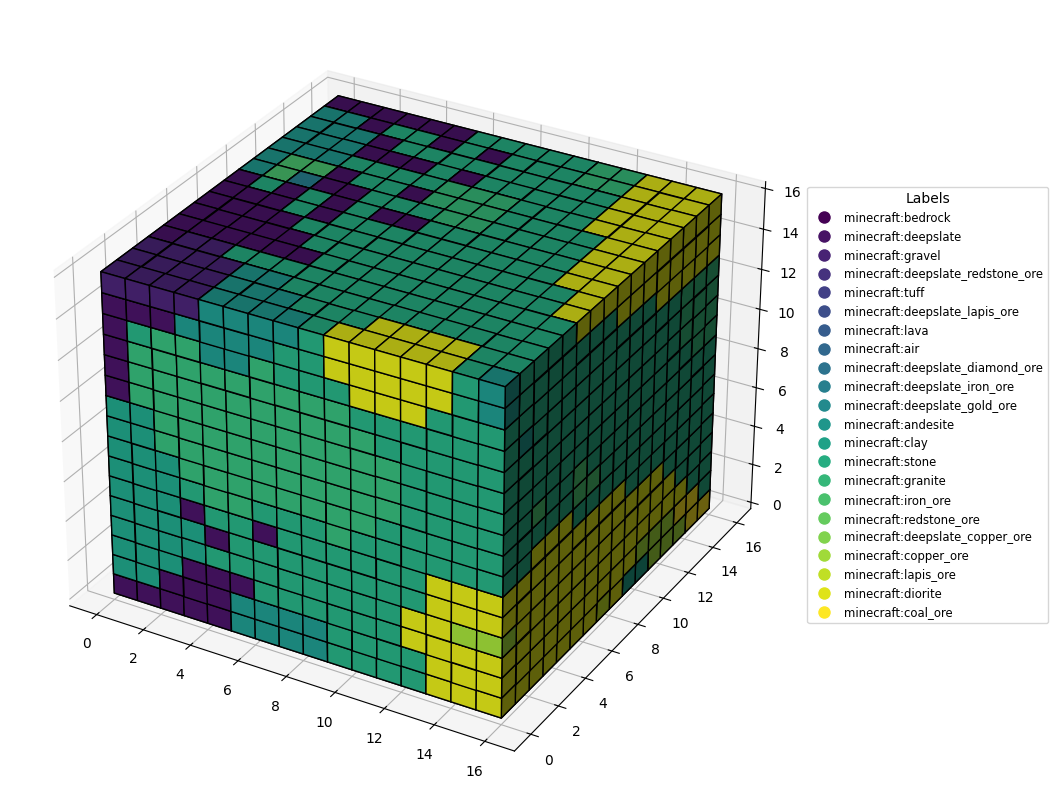

TAG_Byte(1, 'Y')
current_idx=4096
yxz_coords=(16, 0, 0)
current_idx=4097
yxz_coords=(16, 1, 0)
current_idx=4098
yxz_coords=(16, 2, 0)
current_idx=4099
yxz_coords=(16, 3, 0)
current_idx=4100
yxz_coords=(16, 4, 0)
current_idx=4101
yxz_coords=(16, 5, 0)
current_idx=4102
yxz_coords=(16, 6, 0)
current_idx=4103
yxz_coords=(16, 7, 0)


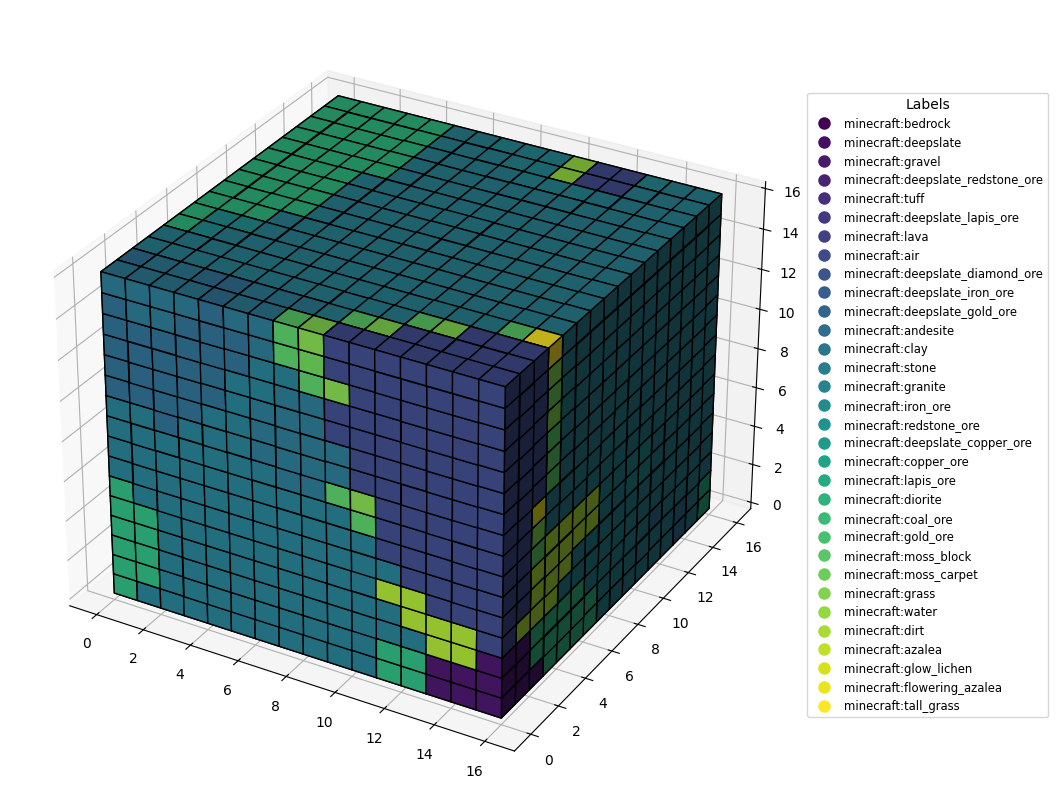

TAG_Byte(2, 'Y')


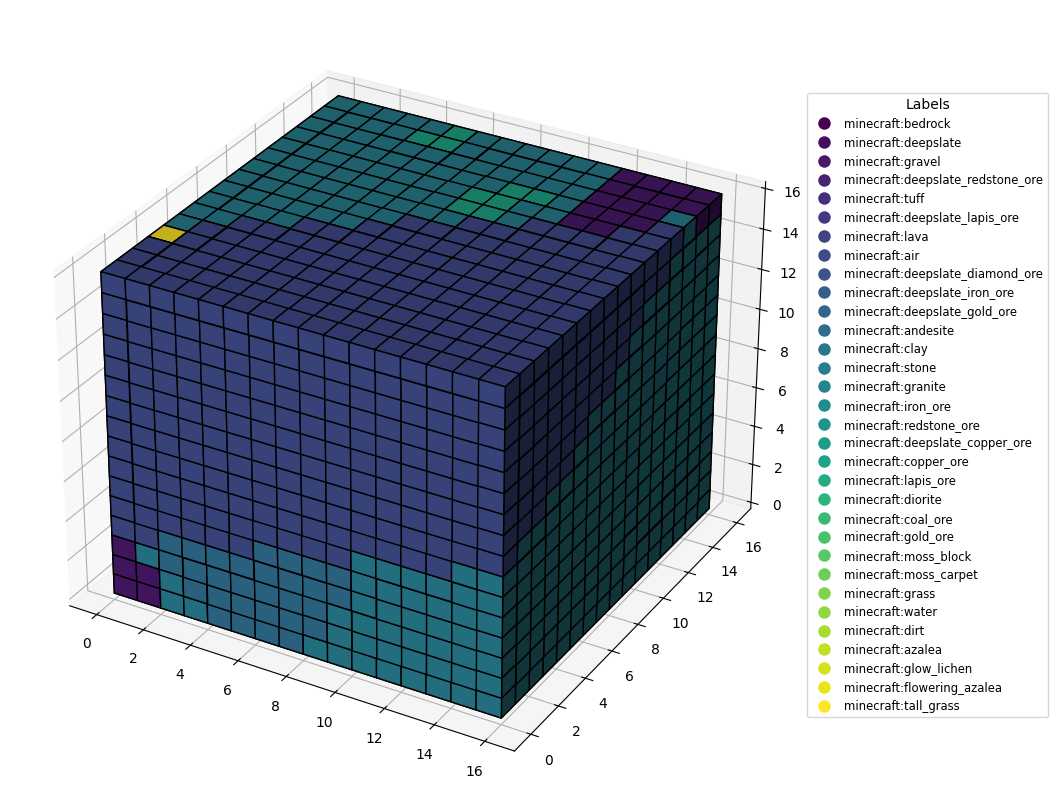

TAG_Byte(3, 'Y')
current_idx=4096
yxz_coords=(16, 0, 0)
current_idx=4097
yxz_coords=(16, 1, 0)
current_idx=4098
yxz_coords=(16, 2, 0)
current_idx=4099
yxz_coords=(16, 3, 0)
current_idx=4100
yxz_coords=(16, 4, 0)
current_idx=4101
yxz_coords=(16, 5, 0)
current_idx=4102
yxz_coords=(16, 6, 0)
current_idx=4103
yxz_coords=(16, 7, 0)


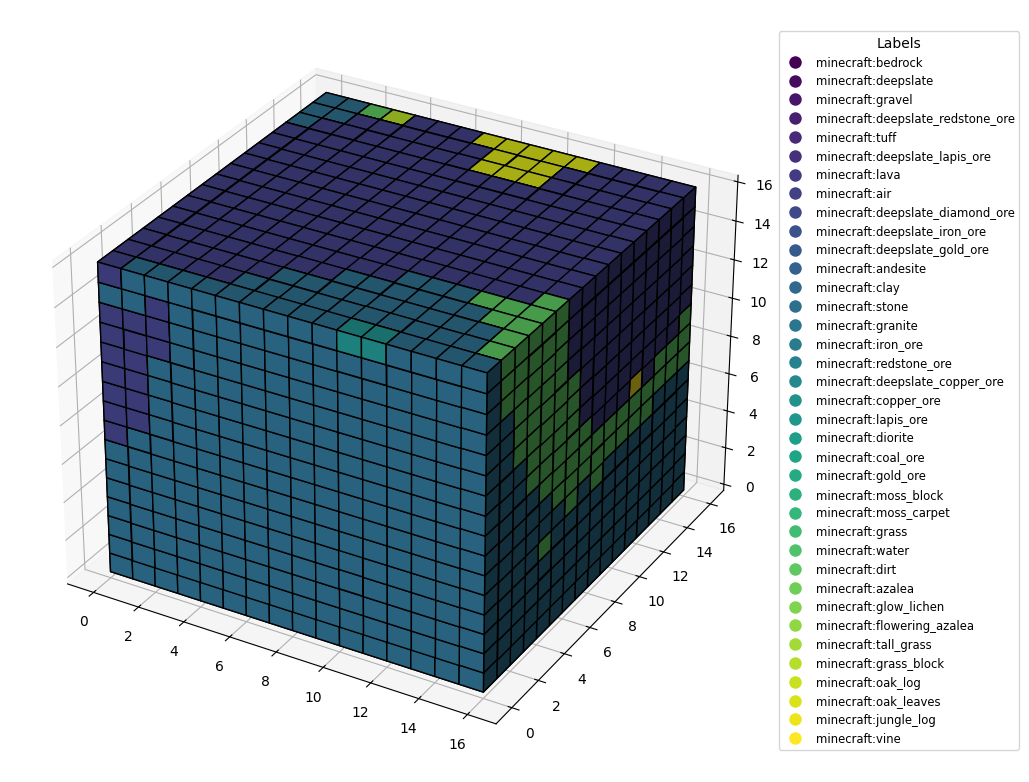

TAG_Byte(4, 'Y')
current_idx=4096
yxz_coords=(16, 0, 0)
current_idx=4097
yxz_coords=(16, 1, 0)
current_idx=4098
yxz_coords=(16, 2, 0)
current_idx=4099
yxz_coords=(16, 3, 0)
current_idx=4100
yxz_coords=(16, 4, 0)
current_idx=4101
yxz_coords=(16, 5, 0)
current_idx=4102
yxz_coords=(16, 6, 0)
current_idx=4103
yxz_coords=(16, 7, 0)


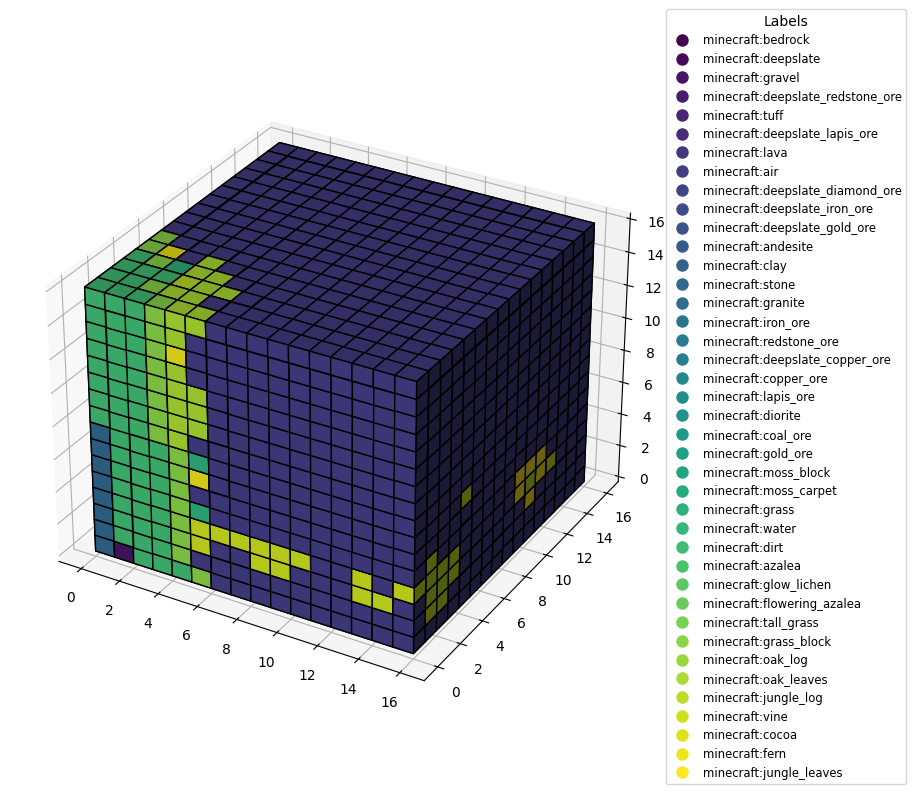

TAG_Byte(5, 'Y')


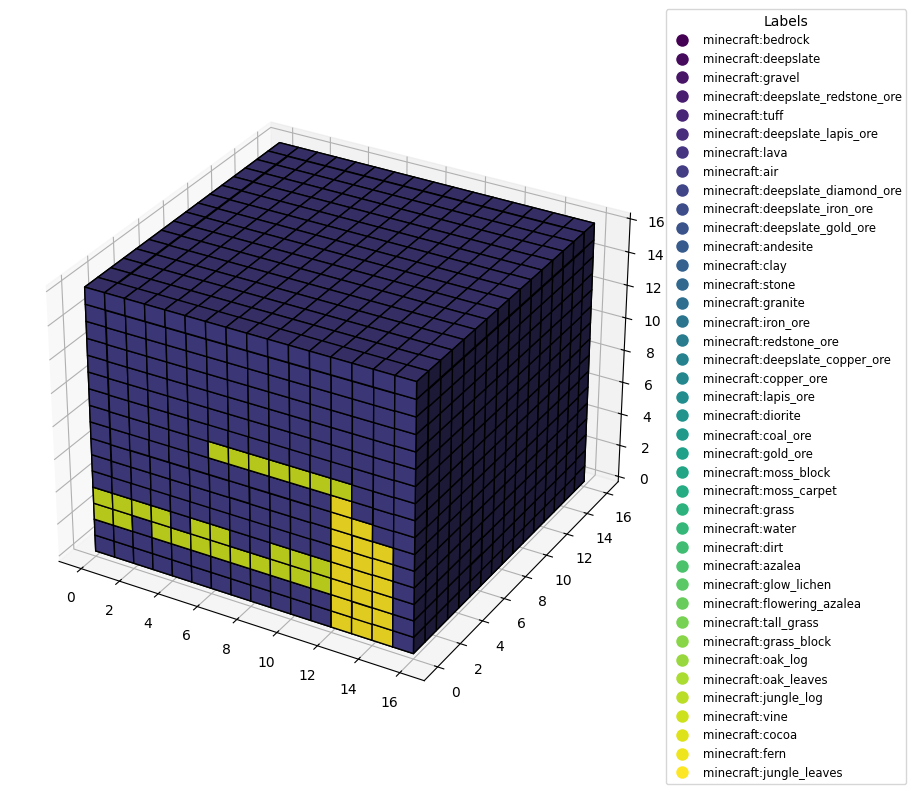

TAG_Byte(6, 'Y')


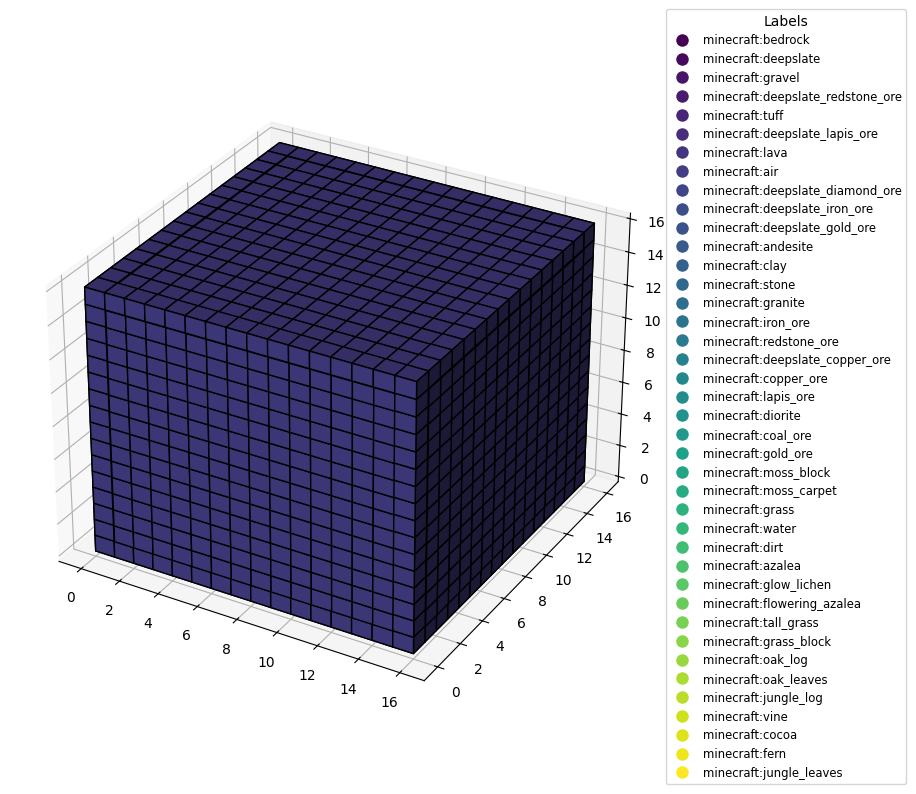

TAG_Byte(7, 'Y')


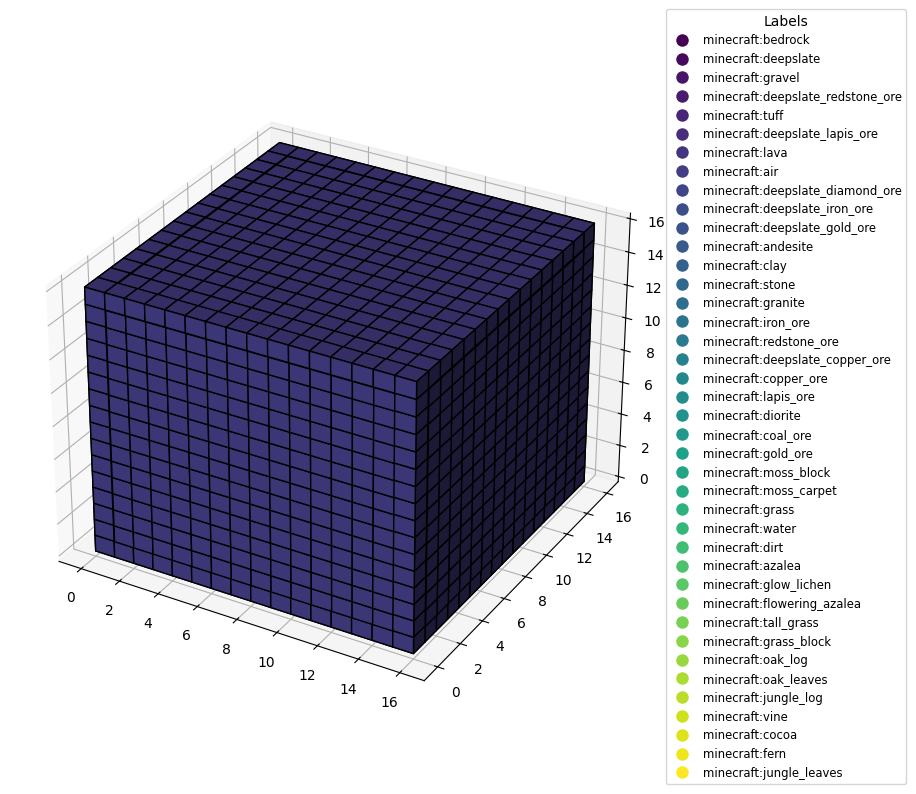

TAG_Byte(8, 'Y')


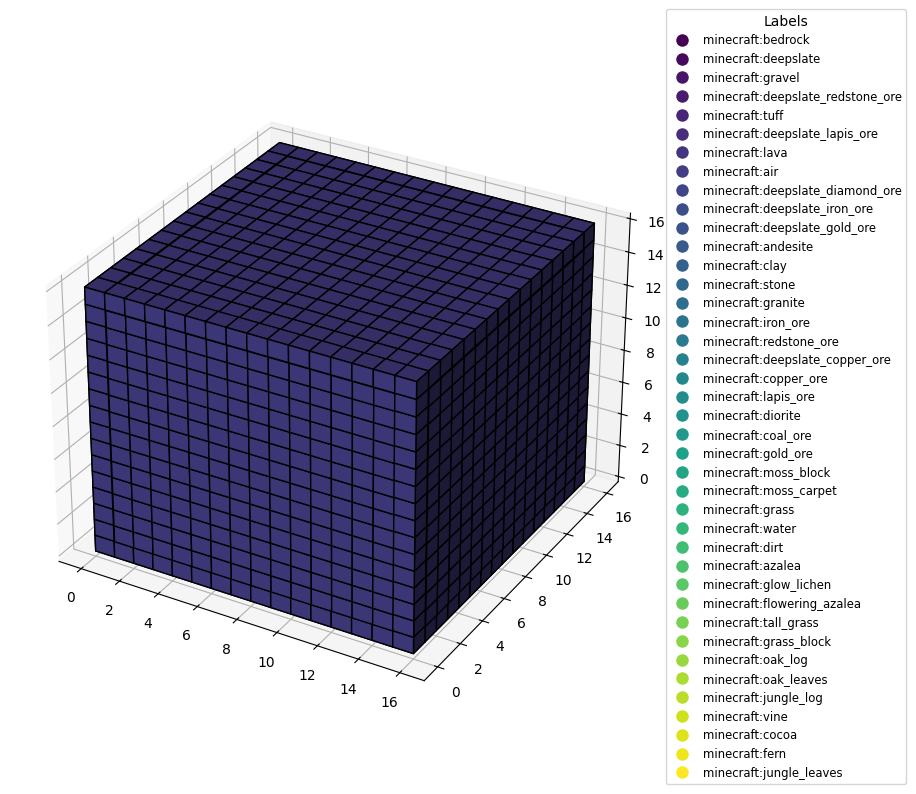

TAG_Byte(9, 'Y')


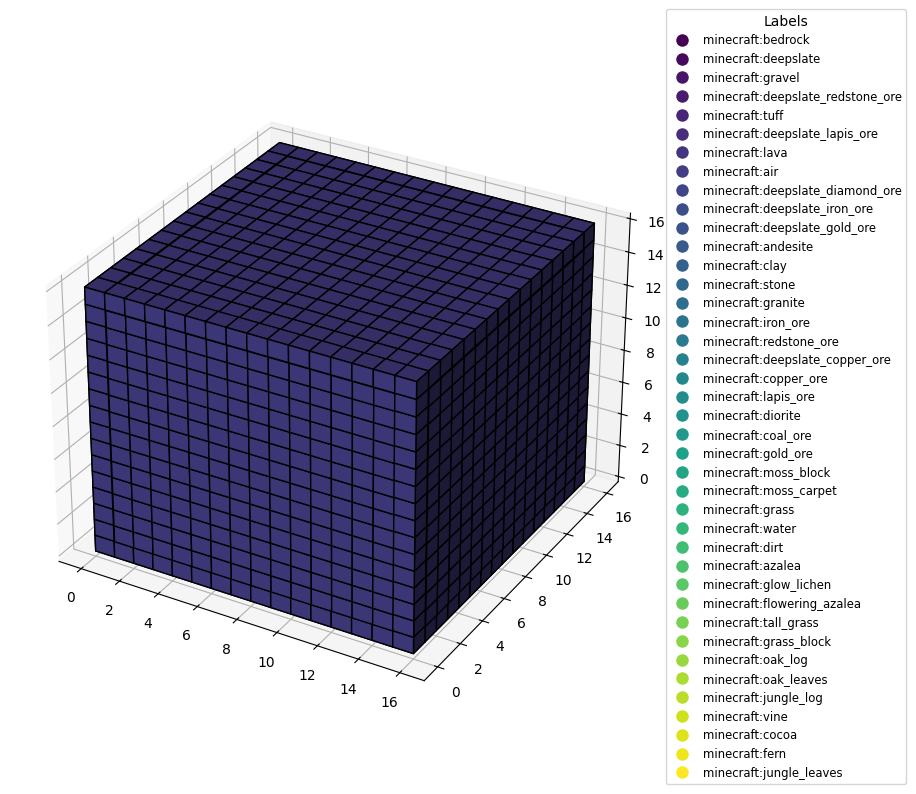

TAG_Byte(10, 'Y')


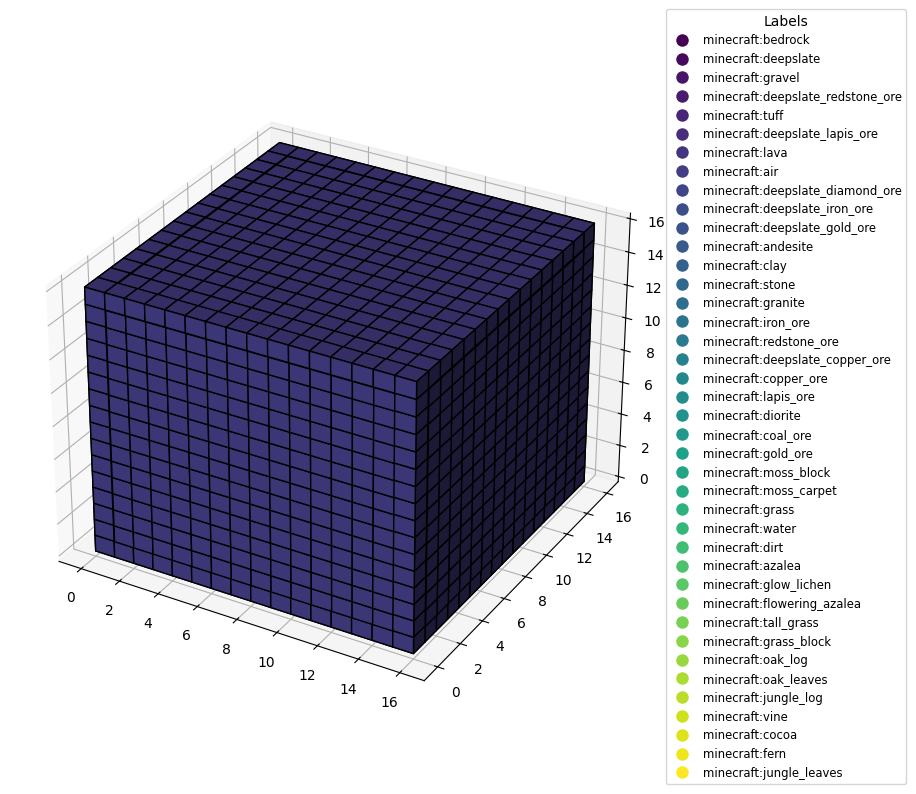

TAG_Byte(11, 'Y')


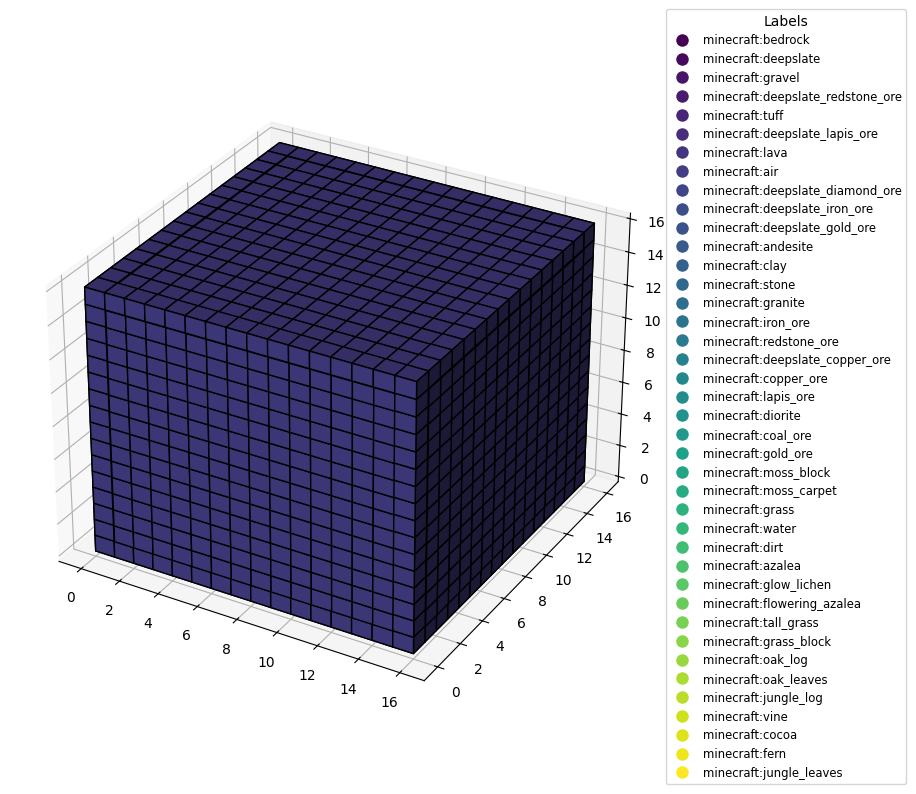

TAG_Byte(12, 'Y')


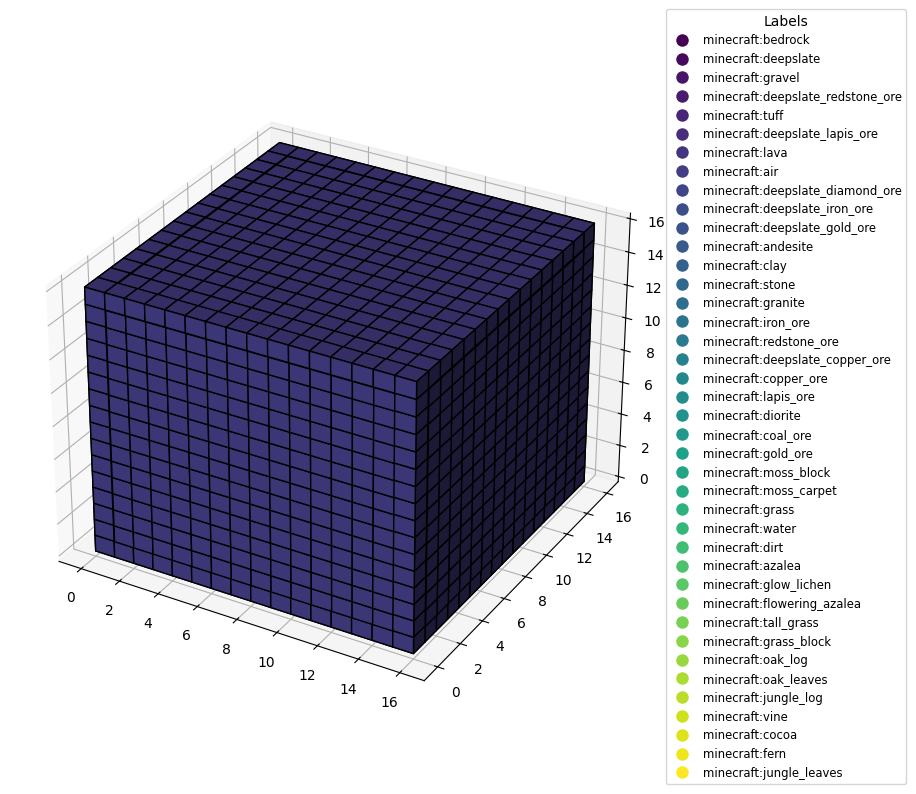

TAG_Byte(13, 'Y')


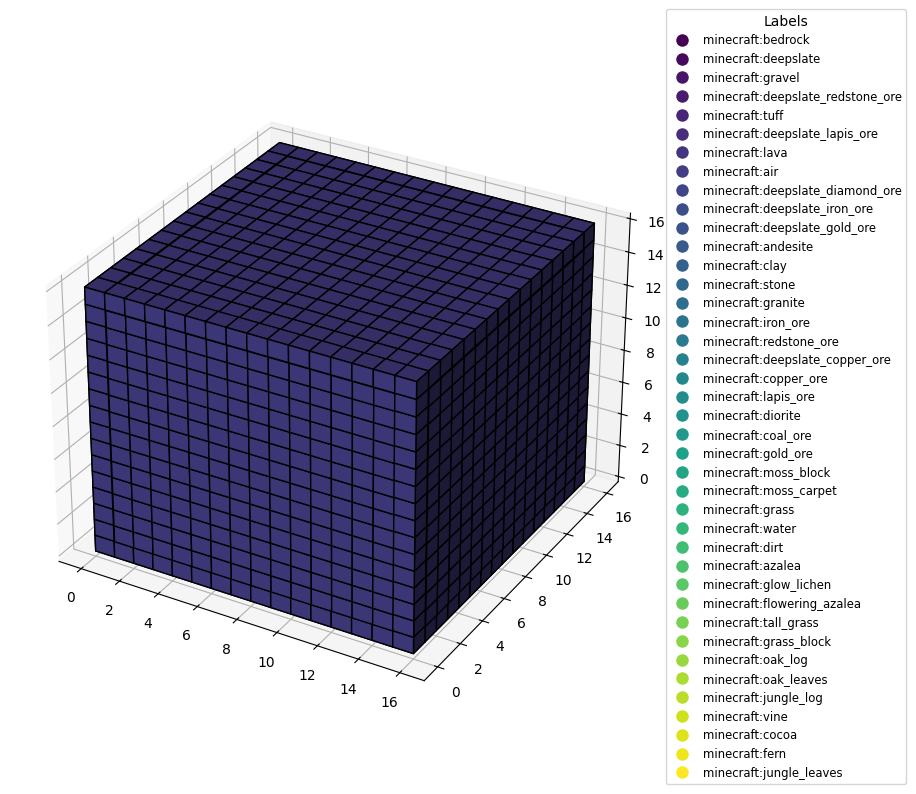

TAG_Byte(14, 'Y')


In [ ]:
read_chunk(all_chunks[(3, 26)], biome_full_palette, block_full_palette)